In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import VGG16_Weights,ResNet18_Weights

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import STL10 dataset

In [3]:
### Note: resnet is trained for images in a specific range (NOT [-1,1]).
#         That changes the mean/std normalization values in the transform.

# transformations
transform = T.Compose([ T.ToTensor(), # normalizes to range [0,1]
                        T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.STL10(root='./data', download=True, split='train', transform=transform)
testset  = torchvision.datasets.STL10(root='./data', download=True, split='test',  transform=transform)

# transform to dataloaders
batchsize    = 256
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(testset, batch_size=256)

100%|██████████| 2.64G/2.64G [04:31<00:00, 9.73MB/s]


In [4]:
# check out the shape of the datasets
print('Data shapes (train/test):')
print( trainset.data.shape )
print( testset.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(np.uint8(0), np.uint8(255))

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [5]:
X,y = next(iter(train_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([256, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


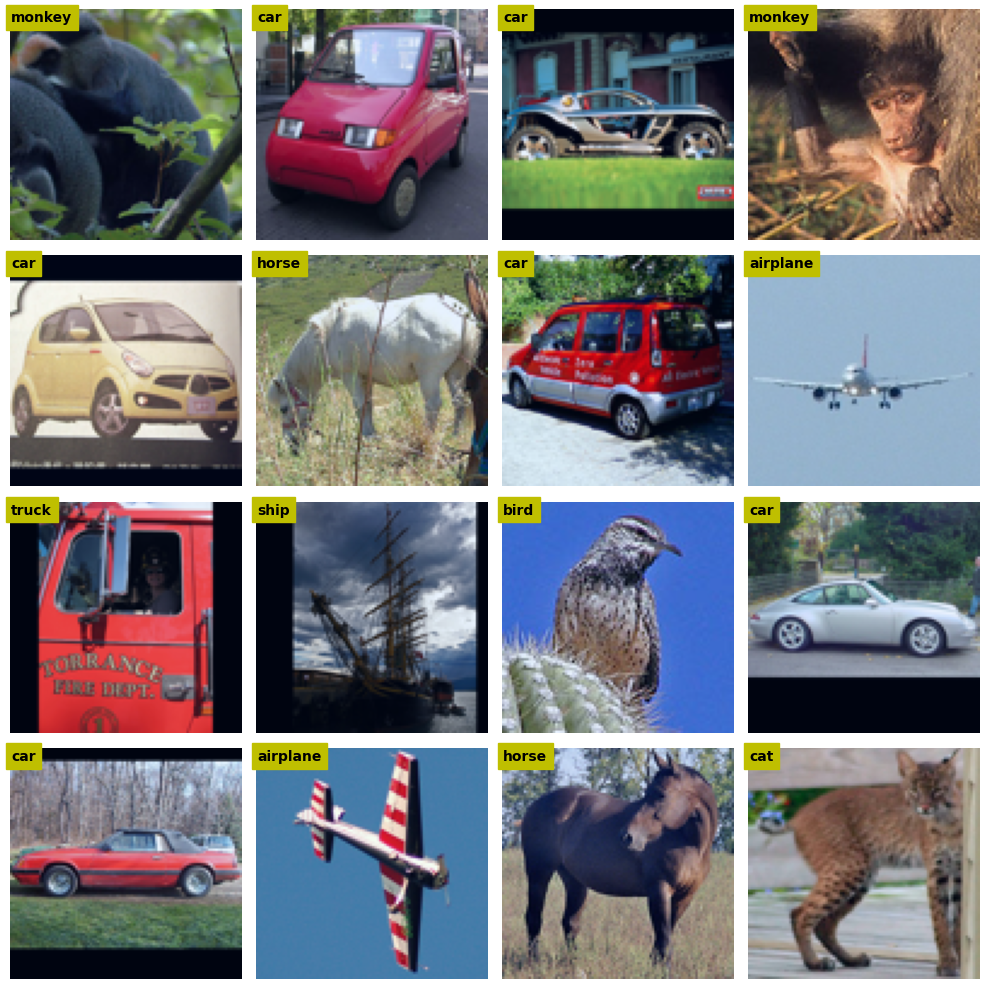

In [6]:
# inspect a few random images

fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 32x32x3)
  pic = X.data[i].numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Import and inspect the resnet model

In [7]:
vgg16 = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 178MB/s]


In [8]:
from torchsummary import summary
summary(vgg16.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [9]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freeze parameters

In [10]:
for p in vgg16.parameters():
  p.requires_grad = False

In [25]:
# change the final layer
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features,10)

In [26]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train the model

In [27]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(),lr=0.001)

In [29]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vgg16.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = vgg16(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  vgg16.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = vgg16(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 90.87%
Finished epoch 2/10. Test accuracy = 91.19%
Finished epoch 3/10. Test accuracy = 91.63%
Finished epoch 4/10. Test accuracy = 91.75%
Finished epoch 5/10. Test accuracy = 91.70%
Finished epoch 6/10. Test accuracy = 91.82%
Finished epoch 7/10. Test accuracy = 91.86%
Finished epoch 8/10. Test accuracy = 91.81%
Finished epoch 9/10. Test accuracy = 91.81%
Finished epoch 10/10. Test accuracy = 91.83%


# Visualize the performance

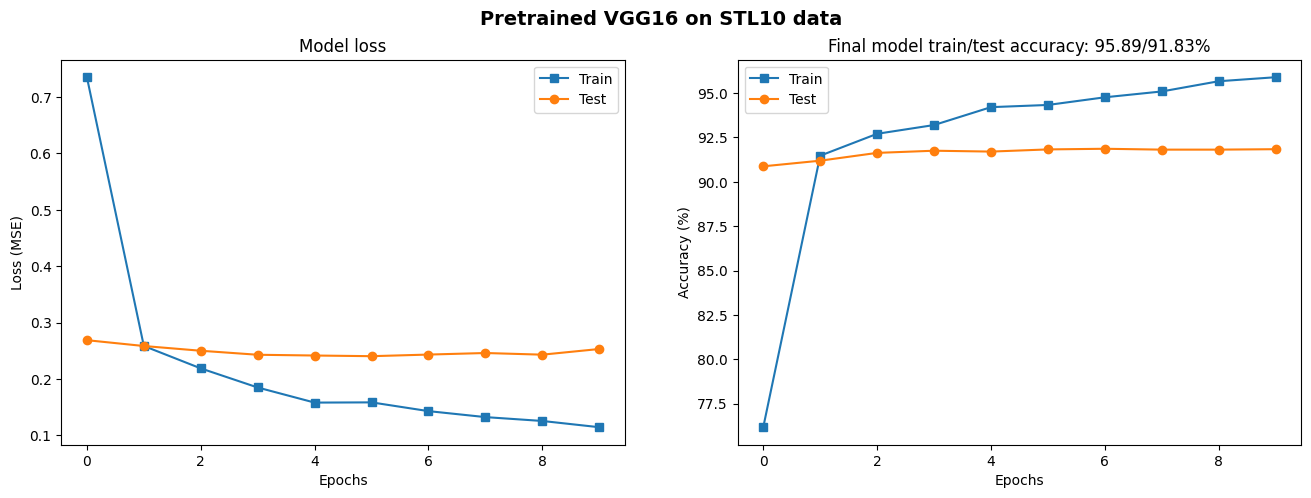

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG16 on STL10 data',fontweight='bold',fontsize=14)
plt.show();

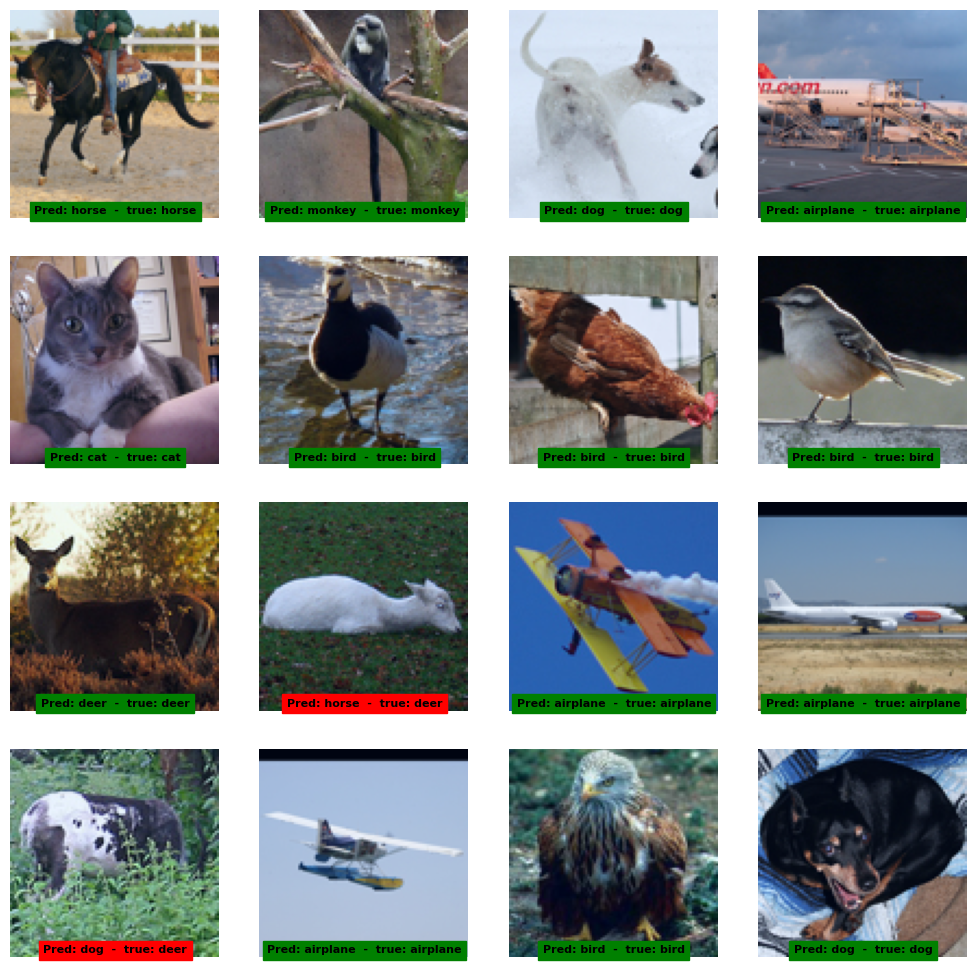

In [32]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
vgg16.eval()
predictions = torch.argmax( vgg16(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  # show the image
  ax.imshow(pic)


  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()